In [2]:
from google.colab import auth
auth.authenticate_user()

# What determines AirBnB Listing Prices in NYC?

#### Access Tableau dashboard here: [Team 4A Dashboard](https://prod-useast-a.online.tableau.com/#/site/soltaniehha/workbooks/253167?:origin=card_share_link)



----------------------

Our goal is to identify factors that determine AirBnB listing prices in New York City by conducting the following tasks:
- Conduct data exploration to see if we can derive any key insights from the dataset variables, specifically how much the variables already included in the dataset explain the prices (e.g. how does review count affect prices?)
- Leverage visualization tools to show the impact of neighborhood location on prices and explore other factors that may explain what elements of a neighborhood may affect prices (using supplementary datasets)
    - Crime
    - Transportation accessibility
    - Cost of Living/real estate prices
    
Ultimately, we hope to help AirBnB renters determine the best price to list for their rentals and improve the descriptions of their listings.


### Data Sources


The scope of our project will be based on the dataset below, consisting of AirBnB listings in New York City from 2019. It seems the prices listed in the dataset are prices for the listing at the time the data was collected.

##### Primary Source: https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data

##### Secondary Sources:
- NYPD Complaint Data Historic - all valid felony, misdemeanor, and violation crimes reported to the New York City Police Department (NYPD) from 2006 to end of 2019.
    - https://data.cityofnewyork.us/Public-Safety/NYPD-Complaint-Data-Historic/qgea-i56i
- NYPD MTA Stations - record of all MTA subway stations in NYC
    http://web.mta.info/developers/data/nyct/subway/Stations.csv
- NYC Property Sales - a record of every building or building unit (apartment, etc.) sold in the New York City property market from 2014-2015 (note: year mismatch)
    - https://www.kaggle.com/new-york-city/nyc-property-sales
    - https://geo.nyu.edu/catalog/nyu-2451-34678
    
Let's take a first look at the data set:

In [3]:
%%bigquery --project ba775-team-4a
SELECT *
FROM `ba775-team-4a.raw_airbnb.airbnb_data`
LIMIT 10;

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,55668,"NOHO/EAST VILLAGE, PRIVATE 1/2 BATH",88209,Jason,Manhattan,NoHo,40.72773,-73.99134,Private room,130,2,115,2018-12-05,1.17,1,75
1,803778,Luxury Loft Noho New York City,4230317,Jenny,Manhattan,NoHo,40.72591,-73.99452,Entire home/apt,465,30,47,2019-05-31,0.67,1,277
2,1818411,HUGE 2bdrm LOFT in NOHO/East Vill!,9522475,Liam,Manhattan,NoHo,40.72569,-73.99227,Entire home/apt,455,30,93,2019-01-03,1.36,2,332
3,2201154,Prime E. Village at St. Marks Place,5081260,Eden,Manhattan,NoHo,40.72780,-73.99205,Private room,208,2,38,2019-06-18,0.60,1,313
4,6747685,Beautiful 1205 ft classic NoHo Loft,29769754,Tom,Manhattan,NoHo,40.72590,-73.99390,Entire home/apt,499,3,35,2019-05-27,0.72,1,223
5,8254674,NOHO ART LOFT ON LAFAYETTE. BEST LOCATION IN NYC,4910739,Max,Manhattan,NoHo,40.72847,-73.99302,Entire home/apt,700,2,31,2019-07-01,1.29,1,54
6,16847069,Prime SOHO Luxury penthouse Loft,62103724,Joe,Manhattan,NoHo,40.72569,-73.99519,Entire home/apt,399,3,51,2019-06-17,1.76,1,336
7,19376872,Sun Filled 18ft Ceiling Duplex Noho/East Village,7107479,Genevieve,Manhattan,NoHo,40.72910,-73.99246,Entire home/apt,191,2,37,2019-05-19,1.50,1,5
8,20016493,"ART LOFT/HOME: DINNERS, GATHERINGS, PHOTO",142118455,Allan,Manhattan,NoHo,40.72560,-73.99487,Entire home/apt,1795,1,38,2019-06-21,1.65,1,116
9,21783251,Separate 2 Bedroom Apartment located inside Loft.,158725307,Greg,Manhattan,NoHo,40.72909,-73.99125,Entire home/apt,200,2,81,2019-06-21,4.24,2,194


------------------

## Exploratory Questions:



### Reviews (Total and Monthly)

- How many reviews does a listing get on average?
- Breaking into quintiles of listing price, what is the average review count for each quintile?
- Breaking into quintiles of review count, what is the average price for each quintile?
    - controlling for other variables
- What is the correlation between the number of reviews and the listing price?
- What is the correlation between the number of reviews per month and the listing price?

### Availability
- How many days on average is a listing in NYC available for in a year?
- Breaking into quintiles of listing availability, what is the average price for each quintile?
    - controlling for other variables
- What is the correlation between the availability throughout the year and the listing price?
 
### Listing Type
- Does the listing type affect price (e.g. Entire house vs shared room)?
- Which listing type is most expensive on average?

### Neighborhood Group
- What is the correlation between the listing neighborhood locations and the price?
    - What could be causing this?
        - Crime?
        - Trasnportation & Accessibility?
        - Cost of Living?
        - Real estate prices?

------------

## Reviews (Total)
For this section, we will explore the *number_of_reviews* variable, which states the number of reviews the listing has.

#### How many reviews does a listing get on average?

In [4]:
%%bigquery --project ba775-team-4a
SELECT
    ROUND(AVG(number_of_reviews),2) as Average_reviews,
FROM `ba775-team-4a.raw_airbnb.airbnb_data`

,Average_reviews
0,23.27


An AirBnB listing in NYC will recieve 23.27 reviews on average.

#### Are there any major disrepencies in the average number of reviews between the locations?

In [5]:
%%bigquery --project ba775-team-4a
SELECT
    neighbourhood_group,
    avg(number_of_reviews) as Average_reviews,
FROM `ba775-team-4a.raw_airbnb.airbnb_data`
GROUP BY neighbourhood_group
ORDER BY Average_reviews

,neighbourhood_group,Average_reviews
0,Manhattan,20.985596
1,Brooklyn,24.202845
2,Bronx,26.004583
3,Queens,27.700318
4,Staten Island,30.941019


Upon first look, there seems to be no major difference in the number of reviews among the boroughs, with each borough differing in the average amount by no more than 4 reviews. Deeper statistical analysis may be required to draw a firm conclusion.

It also seems there are '0' values in the number of reviews. While the lack of reviews may be attributed to the fact that the listing is new or simply lacks reviews, it could also be a null value where the listing may be old and has not been removed from the data set. What happens when we filter them out?

In [6]:
%%bigquery --project ba775-team-4a
SELECT
    ROUND(AVG(number_of_reviews),2) as Average_reviews,
FROM `ba775-team-4a.raw_airbnb.airbnb_data`
WHERE number_of_reviews > 0

,Average_reviews
0,29.3


In [7]:
%%bigquery --project ba775-team-4a
SELECT
    neighbourhood_group,
    avg(number_of_reviews) as Average_reviews,
FROM `ba775-team-4a.raw_airbnb.airbnb_data`
WHERE number_of_reviews > 0
GROUP BY neighbourhood_group
ORDER BY Average_reviews

,neighbourhood_group,Average_reviews
0,Manhattan,27.330988
1,Brooklyn,29.584362
2,Bronx,32.386986
3,Queens,34.313511
4,Staten Island,36.754777


The average values have risen in both tables, which is to be expected. It seems that it has improved the variation between neighborhood groups but not by very much. Again, deeper analysis may be required to make statistical inference.

Moving forward, due to minimal changes to the average values, we will not be filtering out zero-review listings in case we end up excluding new future listings that will have no reviews associated with them.

#### Which listings have the highest amount of reviews? What are their prices?

In [8]:
%%bigquery --project ba775-team-4a
SELECT name,price,
    number_of_reviews as Average_reviews,
    room_type
FROM `ba775-team-4a.raw_airbnb.airbnb_data`
ORDER BY number_of_reviews DESC limit 10;

,name,price,Average_reviews,room_type
0,Room near JFK Queen Bed,47,629,Private room
1,Great Bedroom in Manhattan,49,607,Private room
2,Beautiful Bedroom in Manhattan,49,597,Private room
3,Private Bedroom in Manhattan,49,594,Private room
4,Room Near JFK Twin Beds,47,576,Private room
5,Steps away from Laguardia airport,46,543,Private room
6,Manhattan Lux Loft.Like.Love.Lots.Look !,99,540,Private room
7,Cozy Room Family Home LGA Airport NO CLEANING FEE,48,510,Private room
8,Private brownstone studio Brooklyn,160,488,Entire home/apt
9,LG Private Room/Family Friendly,60,480,Private room


It seems that the 10 most reviewed listings are private rooms (with one exception) with varying prices, ranged from 46-99 dollars (excluding the lonely *Entire home/apt* type)

Let's take a look and see if there is a correlation between price and the average number of reviews.
#### Breaking into quintiles of listing price, what is the average review count for each quintile?

In [9]:
%%bigquery --project ba775-team-4a
SELECT 
AVG(number_of_reviews) avg_reviews,
AVG(price) avg_price,
price_quintile FROM(SELECT number_of_reviews, price,
NTILE(5) OVER(ORDER BY price DESC) AS price_quintile 
FROM `raw_airbnb.airbnb_data`
WHERE price>0) 
GROUP BY price_quintile 
ORDER BY price_quintile ASC

,avg_reviews,avg_price,price_quintile
0,16.236473,371.322696,1
1,25.606628,161.167434,2
2,27.754321,108.794415,3
3,26.785210,75.522246,4
4,19.976984,46.957651,5


The query showss a bell shape curve as the relationship between price and review count. We can see that as the price increases, the reviews count adds up and then decreases. A possible reason for this is that most people would tend to book and review the room with a medium price (mid-quintiles).

In [10]:
%%bigquery --project ba775-team-4a
SELECT 
AVG(price) avg_price,
review_quintile,
AVG(number_of_reviews) avg_reviews
FROM
    (SELECT number_of_reviews, price,
    NTILE(5) OVER(ORDER BY number_of_reviews DESC) AS review_quintile 
    FROM `raw_airbnb.airbnb_data`
    WHERE price>0) 
GROUP BY review_quintile 
ORDER BY review_quintile ASC

,avg_price,review_quintile,avg_reviews
0,130.528383,1,91.015547
1,141.711568,2,18.365347
2,148.177253,3,5.487880
3,150.114861,4,1.488800
4,193.247340,5,0.000000


However, when breaking down the quintiles by reviews, a pattern emerges where, on average, the more reviews a listing recieves, the higher the average price.

Let's control for the type of listing and location:

In [11]:
%%bigquery --project ba775-team-4a
SELECT 
AVG(price) avg_price,
review_quintile,
AVG(number_of_reviews) avg_reviews,
room_type, neighbourhood_group
FROM
    (SELECT number_of_reviews, price,
    NTILE(5) OVER(ORDER BY number_of_reviews DESC) AS review_quintile,
     room_type, neighbourhood_group
    FROM `raw_airbnb.airbnb_data`
    WHERE price >0 # AND number_of_reviews <> 0
    AND room_type = 'Private room'
    AND neighbourhood_group = 'Manhattan') 
GROUP BY review_quintile, room_type, neighbourhood_group
ORDER BY review_quintile ASC

,avg_price,review_quintile,avg_reviews,room_type,neighbourhood_group
0,97.441453,1,103.876018,Private room,Manhattan
1,103.310582,2,20.384471,Private room,Manhattan
2,114.639724,3,5.368421,Private room,Manhattan
3,110.959273,4,1.339599,Private room,Manhattan
4,157.552632,5,0.000000,Private room,Manhattan


When controlling for room type and location, the trajectory still holds true but to a lesser degree.

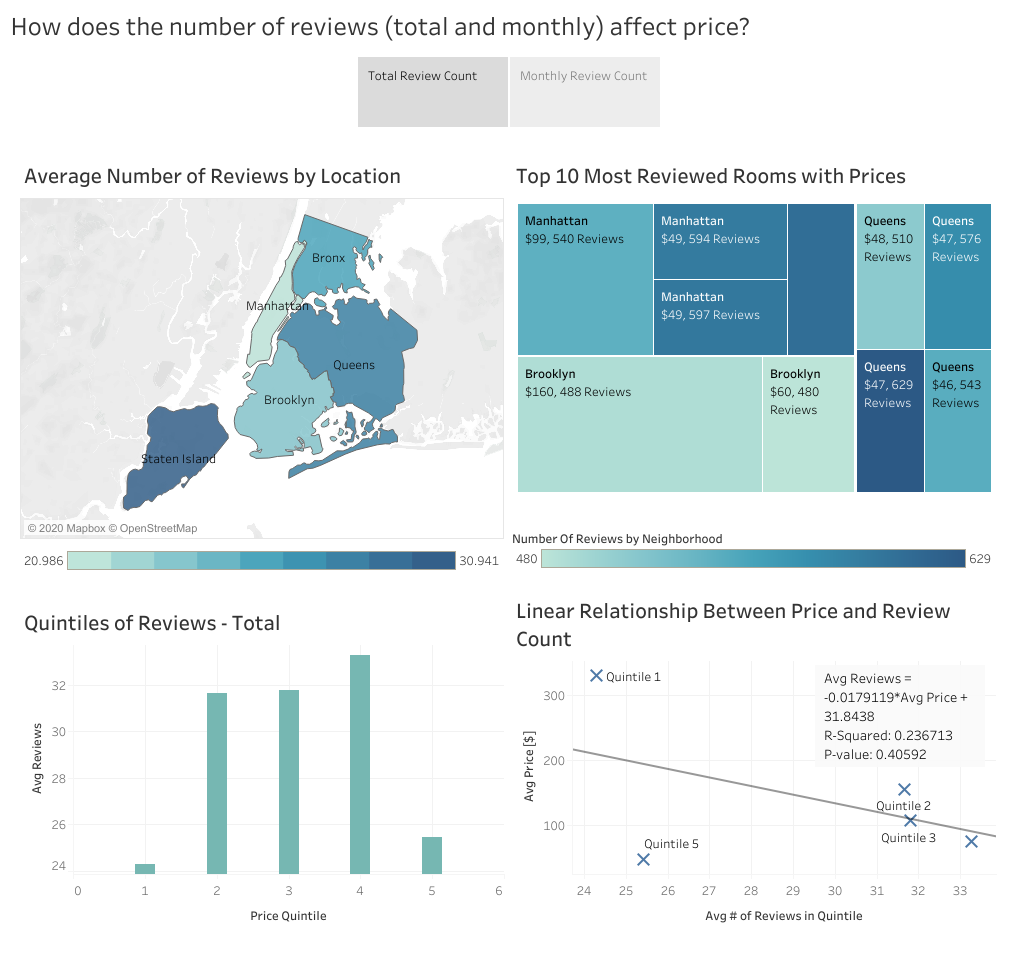

-----

## Reviews per Month

For this section, we will explore the *reviews_per_month* variable, which shows the number of reviews the listing recieves on a regular basis (monthly).


Based on the results in the previous section, it might be worth exploring which listing type has the most reviews on average, the most regular reviews (i.e. reviews per month), and their relationship to price. As some reviews may be dated or listings vary by age (how long it's been on the platform), the reviews_per_month variable is a better measure of popularity.

Let's start by seeing the average number of reviews per month, filtering out listings with 0 monthly reviews (derived from zero-review listings).

In [12]:
%%bigquery --project ba775-team-4a
SELECT  avg(reviews_per_month) avg_monthly_reviews
FROM `ba775-team-4a.raw_airbnb.airbnb_data`
WHERE number_of_reviews > 0

,avg_monthly_reviews
0,1.373221


Which neighborhood has the most popular listing (most regulalry reviewed)?

In [13]:
%%bigquery --project ba775-team-4a
SELECT  name,neighbourhood_group,price,reviews_per_month
FROM `ba775-team-4a.raw_airbnb.airbnb_data`
WHERE number_of_reviews > 0
ORDER BY reviews_per_month DESC limit 10;

,name,neighbourhood_group,price,reviews_per_month
0,Enjoy great views of the City in our Deluxe Room!,Manhattan,100,58.50
1,Great Room in the heart of Times Square!,Manhattan,199,27.95
2,Lou's Palace-So much for so little,Queens,45,20.94
3,JFK Comfort.5 Mins from JFK Private Bedroom & ...,Queens,80,19.75
4,JFK 2 Comfort 5 Mins from JFK Private Bedroom,Queens,50,17.82
5,JFK 3 Comfort 5 Mins from JFK Private Bedroom,Queens,50,16.81
6,Cozy Room Family Home LGA Airport NO CLEANING FEE,Queens,48,16.22
7,Cute Tiny Room Family Home by LGA NO CLEANING FEE,Queens,48,16.03
8,“For Heaven Cakes”,Queens,75,15.78
9,Studio Apartment 6 minutes from JFK Airport,Queens,67,15.32


It seems from this initial query by listing that there is a lot of variation between the price of a listing and the number of regular reviews it gets.

Let's investigate at a high-level, if there seems to be any correlation between number of reviews and the prices.

#### Breaking into quintiles of monthly review count, what is the average price for each quintile?

In [14]:
%%bigquery --project ba775-team-4a
SELECT monthly_review_quintile,
    ROUND(AVG(reviews_per_month),2) AS avg_num_monthly_reviews, 
    ROUND(AVG(price),2) AS avg_price
FROM
    (SELECT price,
     reviews_per_month,
     availability_365,
     NTILE(5) OVER(ORDER BY reviews_per_month DESC) AS monthly_review_quintile 
    FROM `raw_airbnb.airbnb_data`
    WHERE number_of_reviews > 0) 
    GROUP BY monthly_review_quintile 
    ORDER BY avg_num_monthly_reviews DESC

,monthly_review_quintile,avg_num_monthly_reviews,avg_price
0,1,4.09,133.65
1,2,1.71,138.85
2,3,0.73,144.96
3,4,0.27,150.69
4,5,0.07,143.45


From first glance, there seems that the correlation is similar to that of the number of reviews: a bell-shape.

*Controlling for location using most popular location (Queens)*

In [15]:
%%bigquery --project ba775-team-4a
SELECT monthly_review_quintile,
    AVG(reviews_per_month) AS avg_monthly_reviews,
    AVG(price) AS avg_price,
    neighbourhood_group
FROM
(SELECT price, reviews_per_month, NTILE(5) OVER(ORDER BY reviews_per_month DESC) AS monthly_review_quintile, neighbourhood_group
FROM `raw_airbnb.airbnb_data`
WHERE neighbourhood_group = 'Queens' and reviews_per_month <> 0) 
GROUP BY monthly_review_quintile, neighbourhood_group
ORDER BY avg_monthly_reviews DESC

,monthly_review_quintile,avg_monthly_reviews,avg_price,neighbourhood_group
0,1,5.416885,88.397814,Queens
1,2,2.416699,90.837158,Queens
2,3,1.243945,96.527869,Queens
3,4,0.504798,93.479781,Queens
4,5,0.121685,109.585339,Queens


The results are even more sporadic when looking at a specific neighbourhood group. What could be causing this?

Let's see the correlation between listing type, average reviews, average monthly reviews, and price.
#### Which room-type have most reviews and regular reviews? How does price play a factor?

In [16]:
%%bigquery --project ba775-team-4a
SELECT 
    room_type, 
    count(number_of_reviews) as total_listings_of_room_type, 
    avg(number_of_reviews) as Average_reviews,
    avg(reviews_per_month) as Average_reviews_per_month,
    avg(price)as Average_price
FROM `ba775-team-4a.raw_airbnb.airbnb_data`
# WHERE number_of_reviews > 0
GROUP BY room_type
ORDER BY Average_reviews_per_month DESC;

,room_type,total_listings_of_room_type,Average_reviews,Average_reviews_per_month,Average_price
0,Shared room,1160,16.600000,1.471726,70.127586
1,Private room,22326,24.112962,1.445209,89.780973
2,Entire home/apt,25409,22.842418,1.306578,211.794246


It seems that when grouped into the listing type, there is a correlation between the three variables, but the direction of the relationship is not as intuitive.

Based on supply and demand, we expect that the most popular/in-demand type should also have regularly highest prices (vice versa) but that's not the case. This could be explained by the fact that the most popular listing types are the ones that are cheap (low average price).

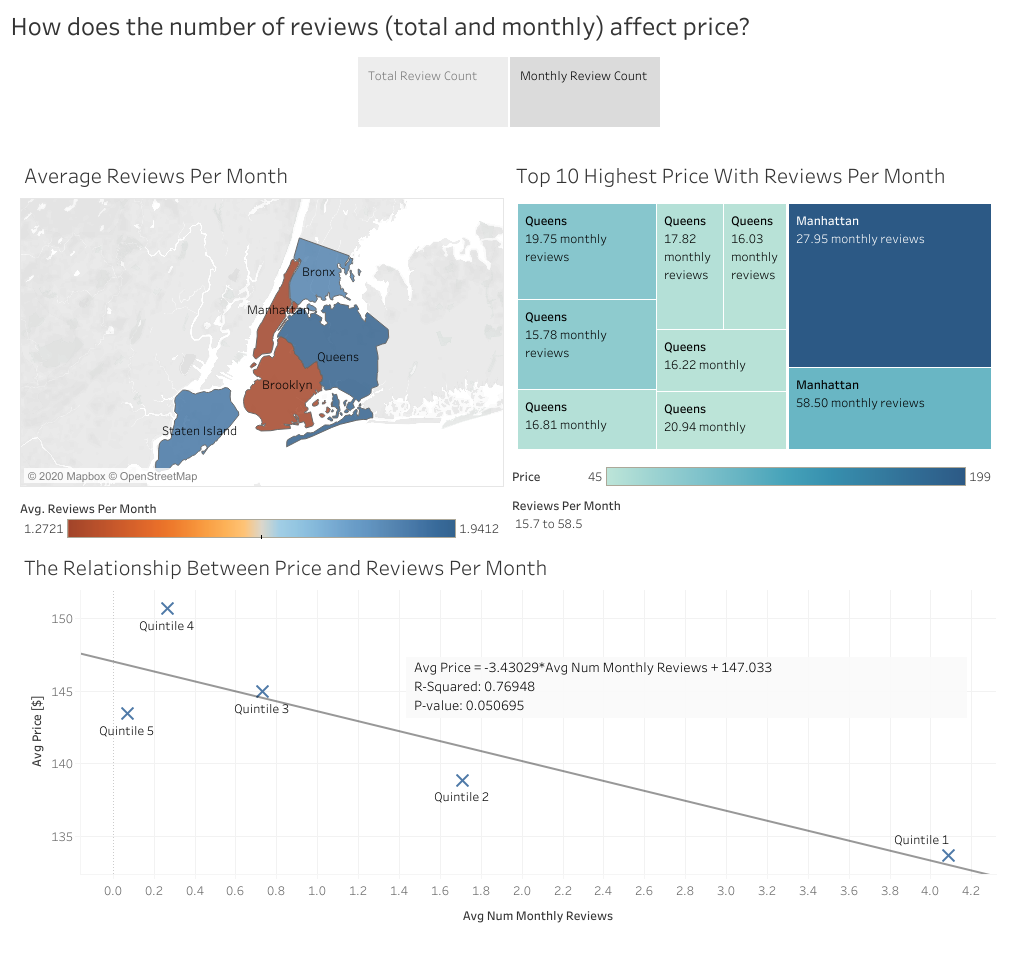

------

## Availability
For this section, we will explore the *availability_365* variable, which states the number of days in a year the listing is avaialble, and its relation to prices.

#### How many days on average is a listing in NYC available for in a year?

In [17]:
%%bigquery --project ba775-team-4a
SELECT ROUND(AVG(availability_365),2) AS avg_annual_availability
FROM `ba775-team-4a.raw_airbnb.airbnb_data`
WHERE availability_365 <> 0

,avg_annual_availability
0,175.83


Breaking down into quintiles, how does the annual availability affect price?

In [18]:
%%bigquery --project ba775-team-4a
SELECT
    availability_quintile,
    AVG(availability_365) AS avg_availability,
    AVG(price) AS avg_price
FROM
    (SELECT price, reviews_per_month,
     availability_365, NTILE(5) OVER(ORDER BY availability_365) AS availability_quintile 
    FROM `raw_airbnb.airbnb_data`) 
GROUP BY availability_quintile 
ORDER BY availability_quintile 

,availability_quintile,avg_availability,avg_price
0,1,0.000000,142.651703
1,2,0.770324,129.026690
2,3,47.790878,143.945700
3,4,183.160753,166.926168
4,5,332.184681,181.053175


When looking at the table, it seems there is a strong correlation between the availability and the average price of a listing.

Something of note is that the last quintile has an average availability is 0. We realize that there may be null listings with 0 avaialabilities throughout the year. 

What happens when we filter them out?

In [19]:
%%bigquery --project ba775-team-4a
SELECT
    availability_quintile,
    AVG(availability_365) AS avg_availability,
    AVG(price) AS avg_price
FROM
    (SELECT price, reviews_per_month,
     availability_365, NTILE(5) OVER(ORDER BY availability_365) AS availability_quintile 
    FROM `raw_airbnb.airbnb_data`
    WHERE availability_365 <> 0) 
GROUP BY availability_quintile 
ORDER BY availability_quintile 

,availability_quintile,avg_availability,avg_price
0,1,15.811095,138.565439
1,2,71.668898,146.692332
2,3,164.697066,163.902902
3,4,276.767219,166.624203
4,5,350.257812,194.473693


It seems the same result is obtained, even after removing null listings.

Let's attempt to control for a given neighbourhood group: Manhattan and Bronx

In [20]:
%%bigquery --project ba775-team-4a
SELECT
    availability_quintile,
    AVG(availability_365) AS avg_availability,
    AVG(price) AS avg_price, location
FROM
    (SELECT price, reviews_per_month,
     availability_365, NTILE(5) OVER(ORDER BY availability_365) AS availability_quintile,
     neighbourhood_group AS location
    FROM `raw_airbnb.airbnb_data`
    WHERE availability_365 <> 0)
WHERE location = 'Manhattan'
GROUP BY availability_quintile,location
ORDER BY availability_quintile

,availability_quintile,avg_availability,avg_price,location
0,1,15.255410,164.023767,Manhattan
1,2,71.150439,197.228583,Manhattan
2,3,166.254050,219.086156,Manhattan
3,4,275.363343,223.595409,Manhattan
4,5,349.299683,264.366163,Manhattan


In [21]:
%%bigquery --project ba775-team-4a
SELECT
    availability_quintile,
    AVG(availability_365) AS avg_availability,
    AVG(price) AS avg_price, location
FROM
    (SELECT price, reviews_per_month,
     availability_365, NTILE(5) OVER(ORDER BY availability_365) AS availability_quintile,
     neighbourhood_group AS location
    FROM `raw_airbnb.airbnb_data`
    WHERE availability_365 <> 0)
WHERE location = 'Bronx'
GROUP BY availability_quintile,location
ORDER BY availability_quintile

,availability_quintile,avg_availability,avg_price,location
0,1,18.102041,76.275510,Bronx
1,2,72.953052,83.309859,Bronx
2,3,162.646766,90.208955,Bronx
3,4,283.666667,87.224359,Bronx
4,5,351.975610,99.162602,Bronx


It seems that in both locations, the correlation still stands true.

What happens when we control for listing type? Let's select *Entire homes/apt* and *Shared rooms*.

In [22]:
%%bigquery --project ba775-team-4a
SELECT
    availability_quintile,
    AVG(availability_365) AS avg_availability,
    AVG(price) AS avg_price, listing_type
FROM
    (SELECT price, reviews_per_month,
     availability_365, NTILE(5) OVER(ORDER BY availability_365) AS availability_quintile,
     room_type AS listing_type
    FROM `raw_airbnb.airbnb_data`
    WHERE availability_365 <> 0)
WHERE listing_type = 'Entire home/apt'
GROUP BY availability_quintile,listing_type
ORDER BY availability_quintile

,availability_quintile,avg_availability,avg_price,listing_type
0,1,15.024390,181.237873,Entire home/apt
1,2,70.792395,207.061322,Entire home/apt
2,3,165.663698,226.985456,Entire home/apt
3,4,274.454521,224.134813,Entire home/apt
4,5,348.159890,294.590283,Entire home/apt


In [23]:
%%bigquery --project ba775-team-4a
SELECT
    availability_quintile,
    AVG(availability_365) AS avg_availability,
    AVG(price) AS avg_price, listing_type
FROM
    (SELECT price, reviews_per_month,
     availability_365, NTILE(5) OVER(ORDER BY availability_365) AS availability_quintile,
     room_type AS listing_type
    FROM `raw_airbnb.airbnb_data`
    WHERE availability_365 <> 0)
WHERE listing_type = 'Shared room'
GROUP BY availability_quintile,listing_type
ORDER BY availability_quintile

,availability_quintile,avg_availability,avg_price,listing_type
0,1,17.413223,66.016529,Shared room
1,2,76.000000,78.818681,Shared room
2,3,168.542056,84.084112,Shared room
3,4,288.171429,62.228571,Shared room
4,5,354.412607,54.882521,Shared room


In [24]:
%%bigquery --project ba775-team-4a
SELECT
    availability_quintile,
    AVG(availability_365) AS avg_availability,
    AVG(price) AS avg_price, listing_type
FROM
    (SELECT price, reviews_per_month,
     availability_365, NTILE(5) OVER(ORDER BY availability_365) AS availability_quintile,
     room_type AS listing_type
    FROM `raw_airbnb.airbnb_data`
    WHERE availability_365 <> 0)
WHERE listing_type = 'Private room'
GROUP BY availability_quintile,listing_type
ORDER BY availability_quintile

,availability_quintile,avg_availability,avg_price,listing_type
0,1,16.880543,79.862565,Private room
1,2,72.226986,95.032787,Private room
2,3,163.385193,90.947067,Private room
3,4,279.737566,85.151233,Private room
4,5,351.793115,114.427011,Private room


It seems that when we control for listing type, the correlation does not appear acurate as it does not summarize a linear relationship between availability and average price under shared room situation. This case may require further investigation as to the reasoning behind.

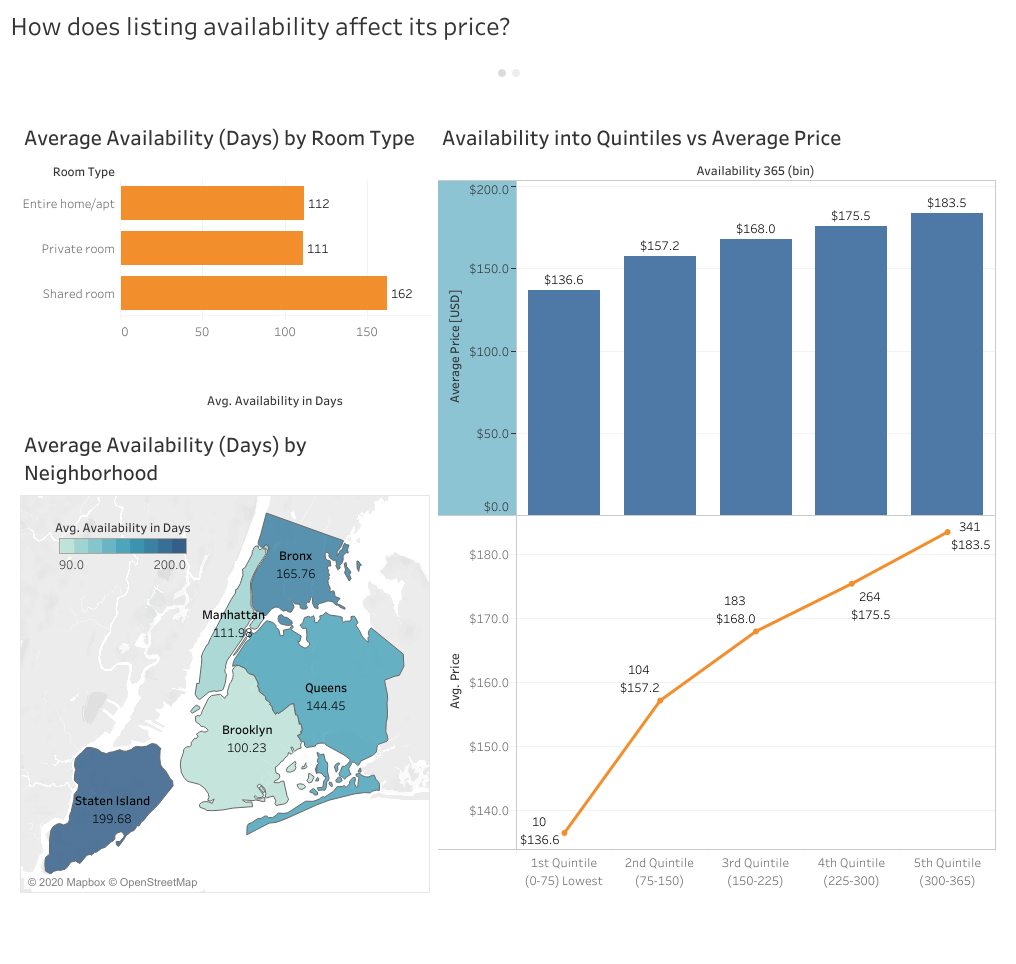

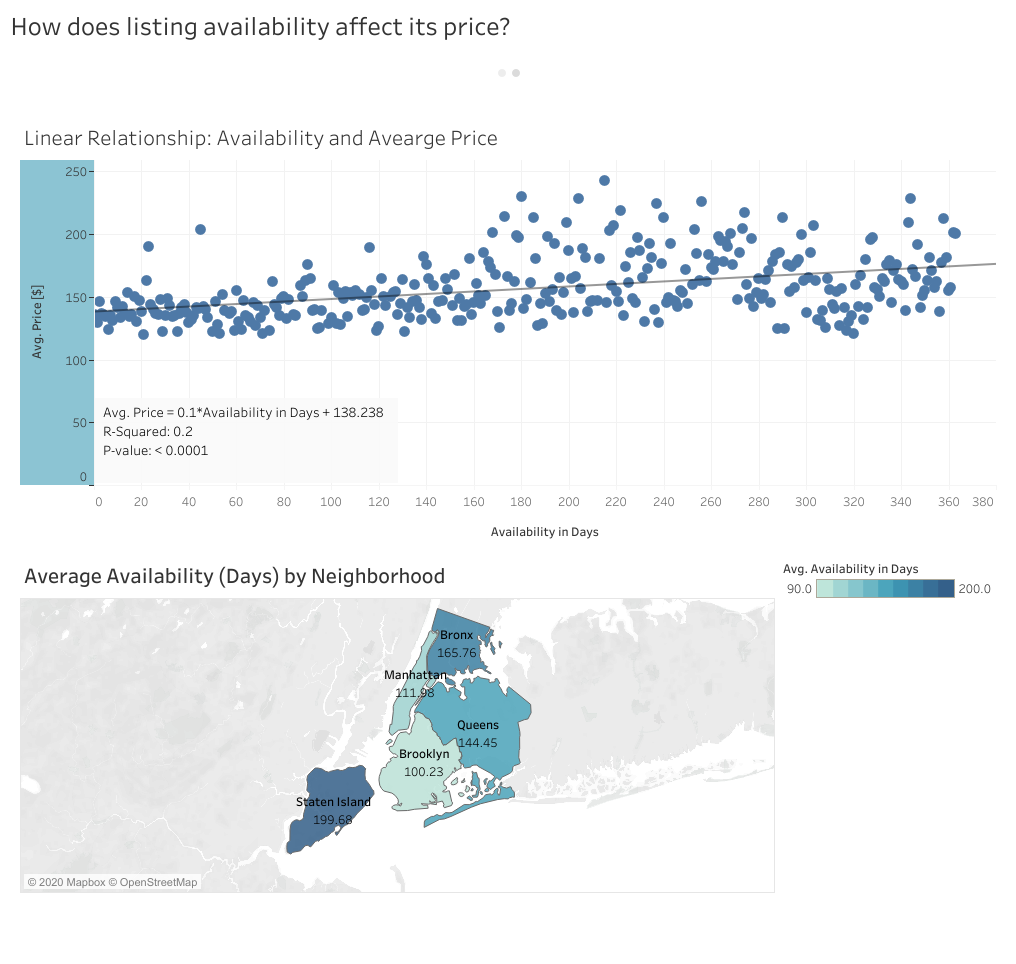

-----

## Listing Type
For this section, we will explore the *room_type* variable, which categorizes the listings into the type (Entire home/apt, Private room, Shared room).


Which listing type is most expensive on average?

In [49]:
%%bigquery --project ba775-team-4a
SELECT 
room_type, avg(price)as Average_price, count(room_type)as total_listing_availible  from `ba775-team-4a.raw_airbnb.airbnb_data`

GROUP BY room_type

ORDER BY Average_price DESC;

,room_type,Average_price,total_listing_availible
0,Entire home/apt,211.794246,25409
1,Private room,89.780973,22326
2,Shared room,70.127586,1160


As we can see from the table, that *Entire home/Apt* rental  is the most expensive type of listing on Airbnb with an avarage price of $211.79, more than double than the second most expensive *Private room*.

This result illustrates that the more privacy renters have in the space, the more the listing will likely be priced. However, it would be interesting to find out if different areas or numbers of reviews collected will affect this tendancy.


#### *Does the listing type affect price (e.g. Entire house vs shared room)?*

It seems that there is a direct correlation between listing price and the type of listing.

In [48]:
%%bigquery --project ba775-team-4a
SELECT 
neighbourhood_group,
neighbourhood, room_type,
round (AVG(price) ,2) as Average_Price,
COUNT(*) Number_of_Listings

FROM `ba775-team-4a.raw_airbnb.airbnb_data`

WHERE neighbourhood_group = 'Manhattan' and neighbourhood = 'SoHo'

GROUP BY neighbourhood_group, neighbourhood, room_type
ORDER BY Average_Price DESC;

,neighbourhood_group,neighbourhood,room_type,Average_Price,Number_of_Listings
0,Manhattan,SoHo,Entire home/apt,365.62,241
1,Manhattan,SoHo,Shared room,147.50,2
2,Manhattan,SoHo,Private room,124.99,115


In [47]:
%%bigquery --project ba775-team-4a
SELECT 
neighbourhood_group,
neighbourhood, room_type,
round (AVG(price) ,2) as Average_Price,
COUNT(*) Number_of_Listings

FROM `ba775-team-4a.raw_airbnb.airbnb_data`

WHERE neighbourhood_group = 'Brooklyn' and neighbourhood = 'DUMBO'

GROUP BY neighbourhood_group, neighbourhood, room_type
ORDER BY Average_Price DESC;

,neighbourhood_group,neighbourhood,room_type,Average_Price,Number_of_Listings
0,Brooklyn,DUMBO,Entire home/apt,217.52,23
1,Brooklyn,DUMBO,Private room,158.77,13


In [46]:
%%bigquery --project ba775-team-4a
SELECT 
neighbourhood_group,
neighbourhood, room_type,
round (AVG(price) ,2) as Average_Price,
COUNT(*) Number_of_Listings

FROM `ba775-team-4a.raw_airbnb.airbnb_data`

WHERE neighbourhood_group = 'Queens' and neighbourhood = 'Jamaica Estates'

GROUP BY neighbourhood_group, neighbourhood, room_type
ORDER BY Average_Price DESC;

,neighbourhood_group,neighbourhood,room_type,Average_Price,Number_of_Listings
0,Queens,Jamaica Estates,Private room,223.00,4
1,Queens,Jamaica Estates,Entire home/apt,172.27,15


I have picked different neighborhoods from different areas to see if the room-type affect the listing price differently. As a result, three different neighborhoods all demostrate that the type of room will inevitably affect the price.

In certain cases, the pattern breaks (e.g. average price for private room will charge more than Entire home/apt). Based on the selected queries, it seems there are fewer listings of that type avaialble in the area which could be driving up the average price. Another explanation could be the significantly maller samples sizes when querying specific neihgborhoods, leading to a contradiction of the initial query with 45,000+ listings to look through.

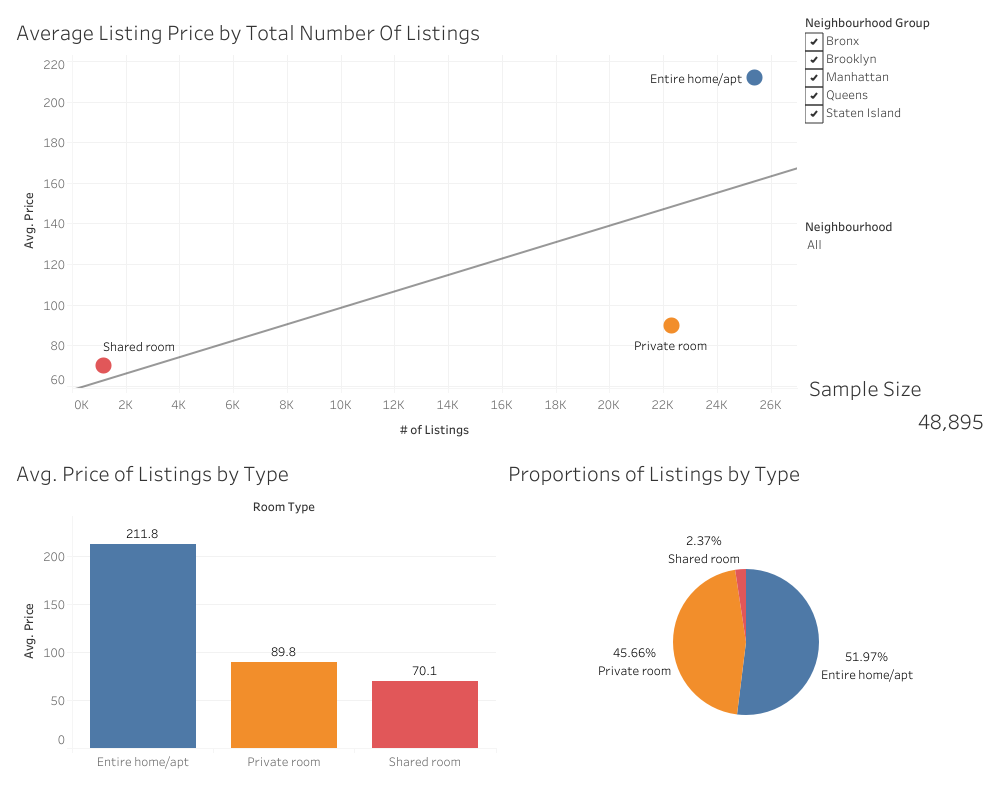

-------

## Location
For this section, we will explore the *neighbourhood_group* and *neighbourhood* variable, which categorizes the listings by their locations (at the borough level and neighborhood level)

Which of the five NYC boroughs have the highest listing prices?

In [45]:
%%bigquery --project ba775-team-4a
SELECT 
neighbourhood_group,
ROUND(AVG(price),2) as Average_Price

FROM `ba775-team-4a.raw_airbnb.airbnb_data`
GROUP BY neighbourhood_group
ORDER BY Average_Price DESC

,neighbourhood_group,Average_Price
0,Manhattan,196.88
1,Brooklyn,124.38
2,Staten Island,114.81
3,Queens,99.52
4,Bronx,87.50


Within the top 3 highest priced boroughs, which neighborhoods have the highest prices?

*Manhattan*

In [44]:
%%bigquery --project ba775-team-4a
SELECT 
neighbourhood_group,
neighbourhood,
ROUND(AVG(price),2) as Average_Price

FROM `ba775-team-4a.raw_airbnb.airbnb_data`

WHERE neighbourhood_group = 'Manhattan'

GROUP BY neighbourhood_group, neighbourhood
ORDER BY Average_Price DESC

LIMIT 5;

,neighbourhood_group,neighbourhood,Average_Price
0,Manhattan,Tribeca,490.64
1,Manhattan,Battery Park City,367.56
2,Manhattan,Flatiron District,341.93
3,Manhattan,NoHo,295.72
4,Manhattan,SoHo,287.10


*Brooklyn*

In [43]:
%%bigquery --project ba775-team-4a
SELECT 
neighbourhood_group,
neighbourhood,
ROUND(AVG(price),2) as Average_Price

FROM `ba775-team-4a.raw_airbnb.airbnb_data`

WHERE neighbourhood_group = 'Brooklyn'

GROUP BY neighbourhood_group, neighbourhood
ORDER BY Average_Price DESC

LIMIT 5;

,neighbourhood_group,neighbourhood,Average_Price
0,Brooklyn,Sea Gate,487.86
1,Brooklyn,Cobble Hill,211.93
2,Brooklyn,Brooklyn Heights,209.06
3,Brooklyn,DUMBO,196.31
4,Brooklyn,Vinegar Hill,187.18


*Staten Island*

In [42]:
%%bigquery --project ba775-team-4a
SELECT 
neighbourhood_group,
neighbourhood,
ROUND(AVG(price),2) as Average_Price

FROM `ba775-team-4a.raw_airbnb.airbnb_data`

WHERE neighbourhood_group = 'Staten Island'

GROUP BY neighbourhood_group, neighbourhood
ORDER BY Average_Price DESC

LIMIT 5;

,neighbourhood_group,neighbourhood,Average_Price
0,Staten Island,Fort Wadsworth,800.0
1,Staten Island,Woodrow,700.0
2,Staten Island,Prince's Bay,409.5
3,Staten Island,Randall Manor,336.0
4,Staten Island,Willowbrook,249.0


Does the number of listings in a given neighborhood affect average price at all?

Let's check for Manhattan!

In [41]:
%%bigquery --project ba775-team-4a
SELECT 
neighbourhood_group,
neighbourhood,
ROUND(AVG(price),2) as Average_Price,
COUNT(*) Number_of_Listings

FROM `ba775-team-4a.raw_airbnb.airbnb_data`

WHERE neighbourhood_group = 'Manhattan'

GROUP BY neighbourhood_group, neighbourhood
ORDER BY Average_Price DESC

LIMIT 10;

,neighbourhood_group,neighbourhood,Average_Price,Number_of_Listings
0,Manhattan,Tribeca,490.64,177
1,Manhattan,Battery Park City,367.56,70
2,Manhattan,Flatiron District,341.93,80
3,Manhattan,NoHo,295.72,78
4,Manhattan,SoHo,287.10,358
5,Manhattan,Midtown,282.72,1545
6,Manhattan,West Village,267.68,768
7,Manhattan,Greenwich Village,263.41,392
8,Manhattan,Chelsea,249.74,1113
9,Manhattan,Theater District,248.01,288


Based on the results, it seems that the three highest priced neighborhoods in Manhattan have fewer listings on average than the rest. With that said, there is plenty of variation which may suggest there's not much correlation in the number of listings with the average price in a given neighborhood.

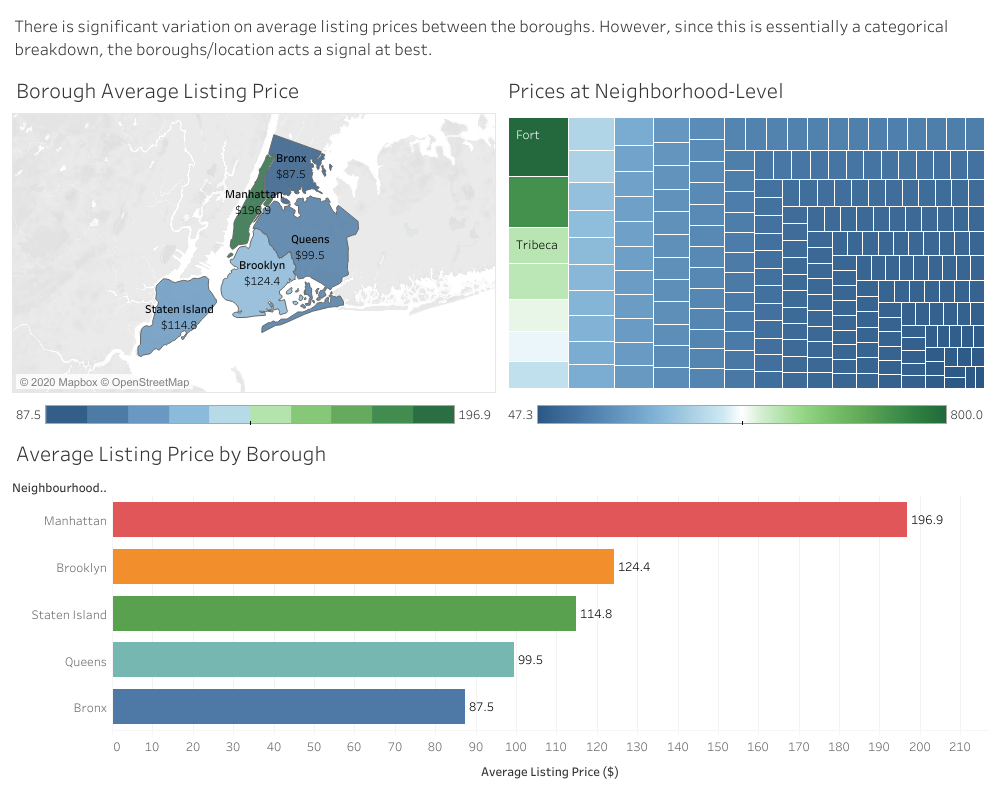

#### Explaining the price disrepencies between neighborhoods
Now that we know the neighborhoods with the highest priced AirBnbs, let's see if we can find a way to explain it. We hypothesize that when considering the average person search for AirBnBs and their locations, most people consider the following factors:
- Safety
- Transportation Accessibility
- Cost of Living (or visiting)

### Safety and Crime
Let's start of by seeing if the crime rates in the different neighborhoods affect prices. For this, we will use the NYPD Complaint Data, which catalogs all valid police complaints from 2006 to 2019. 

*Source: https://data.cityofnewyork.us/Public-Safety/NYPD-Complaint-Data-Historic/qgea-i56i*

In [40]:
%%bigquery --project ba775-team-4a
SELECT * FROM `ba775-team-4a.raw_airbnb.NYC_crime_historic` LIMIT 5

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,CRM_ATPT_CPTD_CD,LAW_CAT_CD,BORO_NM,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,JURIS_DESC,JURISDICTION_CODE,PARKS_NM,HADEVELOPT,HOUSING_PSA,X_COORD_CD,Y_COORD_CD,SUSP_AGE_GROUP,SUSP_RACE,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX
0,740964699,01/23/2015,13:40:00,None,None,22,01/23/2015,359,OFFENSES AGAINST PUBLIC ADMINI,759,"PUBLIC ADMINISTATION,UNCLASS M",COMPLETED,MISDEMEANOR,MANHATTAN,None,STREET,N.Y. POLICE DEPT,0,None,None,NA,993538,222793,None,None,None,None,40.778194947,-73.966465382,"(40.778194947, -73.966465382)",PATROL BORO MAN NORTH,None,None,UNKNOWN,E
1,839963182,04/26/2019,09:00:00,04/26/2019,09:10:00,-99,05/09/2019,114,ARSON,263,"ARSON 2,3,4",COMPLETED,FELONY,BRONX,INSIDE,OTHER,DEPT OF CORRECTIONS,72,None,None,None,1016268,227533,UNKNOWN,BLACK,M,None,40.791151867000053,-73.884371918999989,"(40.79115186700005, -73.88437191899999)",PATROL BORO BRONX,None,UNKNOWN,UNKNOWN,E
2,913263578,09/10/2011,13:20:00,None,None,None,09/10/2011,101,MURDER & NON-NEGL. MANSLAUGHTER,None,None,COMPLETED,FELONY,None,OUTSIDE,None,N.Y. POLICE DEPT,None,NA,None,NA,1054673,178146,25-44,BLACK,M,None,40.655374492,-73.746193759,"(40.655374492, -73.746193759)",None,None,45-64,WHITE,M
3,364445651,06/07/2016,01:29:00,06/07/2016,01:40:00,22,06/07/2016,359,OFFENSES AGAINST PUBLIC ADMINI,750,RESISTING ARREST,COMPLETED,MISDEMEANOR,MANHATTAN,None,PARK/PLAYGROUND,N.Y. POLICE DEPT,0,CENTRAL PARK,None,NA,990508,220370,25-44,BLACK,F,None,40.771547111,-73.977408022,"(40.771547111, -73.977408022)",PATROL BORO MAN NORTH,None,UNKNOWN,UNKNOWN,E
4,629937046,09/16/2006,13:20:00,09/16/2006,13:45:00,22,09/16/2006,232,POSSESSION OF STOLEN PROPERTY,490,"STOLEN PROPERTY 3,POSSESSION",COMPLETED,MISDEMEANOR,MANHATTAN,FRONT OF,PARK/PLAYGROUND,N.Y. POLICE DEPT,0,NA,None,NA,994404,226492,None,None,None,None,40.788346768,-73.963332936,"(40.788346768, -73.963332936)",PATROL BORO MAN NORTH,None,None,UNKNOWN,D


There's a lot of information in this dataset but we're only looking for the the number of crimes reported in 2019 in each NYC borough. We will be using the following columnns to extract this data:
- RPT_DT: the date which the crime was reported
- BORO_NM: the name of the NYC borough
- LAW_CAT_CD: level of offense reported (i.e. the seriousness of the offense); this may not be completely relevant but it may be worth exploring still

In [39]:
%%bigquery --project ba775-team-4a
SELECT COUNT(*) Crimes_Reported, BORO_NM as Borough
FROM `ba775-team-4a.raw_airbnb.NYC_crime_historic`
WHERE EXTRACT(YEAR from (PARSE_DATE('%m/%d/%Y', RPT_DT))) = 2019 # parsing required since data had to imported as a string
AND BORO_NM IS NOT NULL
GROUP BY Borough
ORDER BY Crimes_Reported

,Crimes_Reported,Borough
0,20003,STATEN ISLAND
1,97201,QUEENS
2,104825,BRONX
3,121550,MANHATTAN
4,138382,BROOKLYN


Let's put it together with the AirBnB data

In [38]:
%%bigquery --project ba775-team-4a
SELECT
    airbnb.neighbourhood_group,
    airbnb.Average_Price,
    crime.Crimes_Reported
FROM # used subqueries because boroughs/neighborhoods were not in the same case (e.g MANHATTAN and Manhattan)
  (SELECT 
  UPPER(neighbourhood_group) AS upper_boro,
  neighbourhood_group,
  ROUND(AVG(price),2) as Average_Price

  FROM `ba775-team-4a.raw_airbnb.airbnb_data`
  GROUP BY neighbourhood_group
  ORDER BY Average_Price DESC
  ) AS airbnb
LEFT JOIN 
  (SELECT COUNT(*) Crimes_Reported, BORO_NM as Borough
  FROM `ba775-team-4a.raw_airbnb.NYC_crime_historic`
  WHERE EXTRACT(YEAR from (PARSE_DATE('%m/%d/%Y', RPT_DT))) = 2019 
  AND BORO_NM IS NOT NULL
  GROUP BY Borough
  ORDER BY Crimes_Reported
  ) AS crime
ON airbnb.upper_boro = crime.Borough
ORDER BY Average_Price DESC

,neighbourhood_group,Average_Price,Crimes_Reported
0,Manhattan,196.88,121550
1,Brooklyn,124.38,138382
2,Staten Island,114.81,20003
3,Queens,99.52,97201
4,Bronx,87.50,104825


At a high-level, it seems that there's no correlation with the average AirBnb price and the number of crimes reported in a given neighborhood. Does the severity of the crime matter?

In [37]:
%%bigquery --project ba775-team-4a
SELECT
  airbnb.neighbourhood_group,
  airbnb.Average_Price,
  crime.Crimes_Reported
FROM 
  (SELECT 
  UPPER(neighbourhood_group) AS upper_boro,
  neighbourhood_group,
  ROUND(AVG(price),2) as Average_Price
  FROM `ba775-team-4a.raw_airbnb.airbnb_data`
  WHERE room_type = 'Entire home/apt' # controlling for potential price disrepencies caused by listing types
  GROUP BY neighbourhood_group
  ORDER BY Average_Price DESC
  ) AS airbnb
LEFT JOIN 
  (SELECT COUNT(*) Crimes_Reported, BORO_NM as Borough
  FROM `ba775-team-4a.raw_airbnb.NYC_crime_historic`
  WHERE EXTRACT(YEAR from (PARSE_DATE('%m/%d/%Y', RPT_DT))) = 2019 
  AND BORO_NM IS NOT NULL
  AND LAW_CAT_CD IN ('FELONY','MISDEMEANOR') # added filter to only count felonies and misdemeanors
  GROUP BY Borough
  ORDER BY Crimes_Reported
  ) AS crime
ON airbnb.upper_boro = crime.Borough
ORDER BY Average_Price DESC

,neighbourhood_group,Average_Price,Crimes_Reported
0,Manhattan,249.24,105688
1,Brooklyn,178.33,117135
2,Staten Island,173.85,15786
3,Queens,147.05,81226
4,Bronx,127.51,87458


Even when filtering for serious crimes and controlling for the listing type, there still is no correlation. An explanation for this could be the fact that, although safety may be a concern for renters, there is not enough readily available data out there on crime to make it easy for them to take into consideration during their search. Thus, crime seems to have little to no correlation with the AirBnB listing prices.

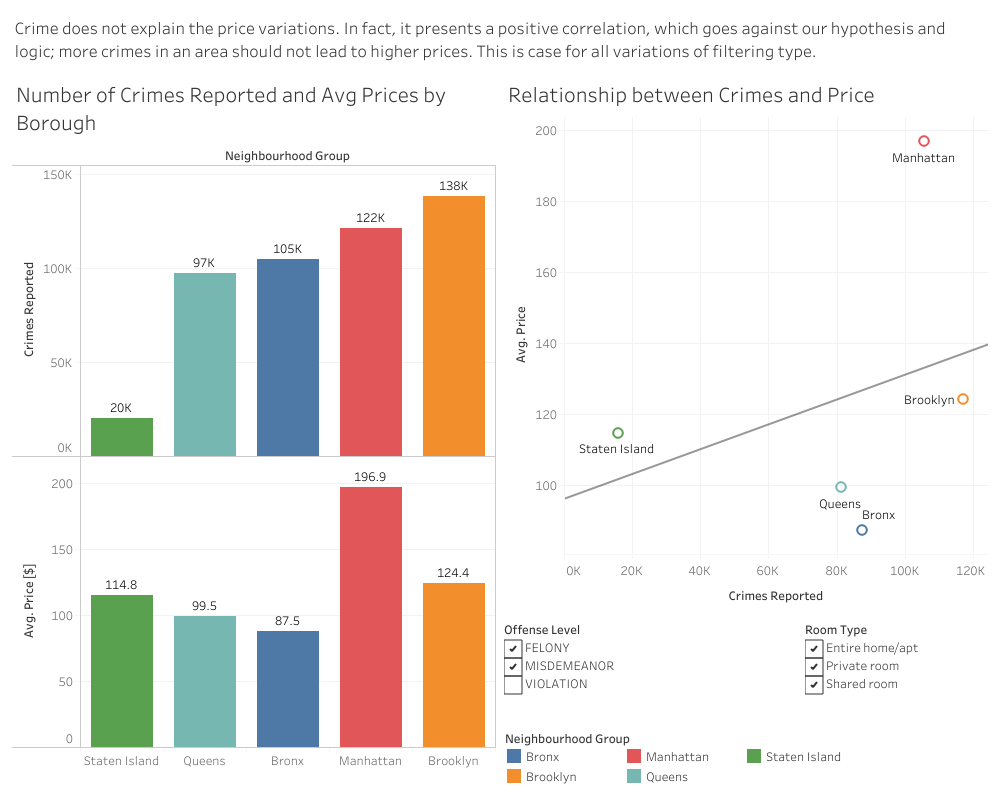

----

### Transportation and Accessibility
Next, let's investigate whether ease of finding transportation plays any factor in driving demand up for a certain neighborhood. A quick Google search shows that the mode of transportation New Yorkers use most is the MTA/subway (39%), so this project will focus on accesibility to subway stations.

Sources: http://web.mta.info/developers/data/nyct/subway/Stations.csv

As many New Yorkers utilize the subway as their main mode of transport in their everyday lives, let's see if the New York MTA plays the same role in predicting AirBnB prices. We will use the dataset from the New York MTA, here's a preview of the raw dataset:

In [34]:
%%bigquery --project ba775-team-4a
SELECT * FROM `ba775-team-4a.raw_airbnb.nyc_subway_stations` LIMIT 5;

,Station_ID,Complex_ID,GTFS_Stop_ID,Division,Line,Stop_Name,Borough,Daytime_Routes,Structure,GTFS_Latitude,GTFS_Longitude,North_Direction_Label,South_Direction_Label,ADA,ADA_Notes
0,7,613,R11,BMT,Astoria,Lexington Av/59 St,M,N W R,Subway,40.762660,-73.967258,Queens,Downtown & Brooklyn,0,None
1,8,8,R13,BMT,Astoria,5 Av/59 St,M,N W R,Subway,40.764811,-73.973347,Queens,Downtown & Brooklyn,0,None
2,9,9,R14,BMT,Broadway - Brighton,57 St-7 Av,M,N Q R W,Subway,40.764664,-73.980658,Uptown & Queens,Downtown & Brooklyn,0,None
3,13,13,R18,BMT,Broadway - Brighton,28 St,M,R W,Subway,40.745494,-73.988691,Uptown & Queens,Downtown & Brooklyn,0,None
4,14,14,R19,BMT,Broadway - Brighton,23 St,M,R W,Subway,40.741303,-73.989344,Uptown & Queens,Downtown & Brooklyn,0,None


With a subquery and CASE function utilization, we can find the find the number of subway stations in each borough. 

In [35]:
%%bigquery --project ba775-team-4a
SELECT COUNT(*) Subway_Station_Count, Borough_Name
FROM
(SELECT Stop_Name, 
  CASE
    WHEN Borough = 'Q' THEN 'Queens'
    WHEN Borough = 'Bx' THEN 'Bronx'
    WHEN Borough = 'Bk' THEN 'Brooklyn'
    WHEN Borough = 'M' THEN 'Manhattan'
    WHEN Borough = 'SI' THEN 'Staten Island'
    END AS Borough_Name
FROM `ba775-team-4a.raw_airbnb.nyc_subway_stations`)

GROUP BY Borough_Name
ORDER BY Subway_Station_Count DESC

,Subway_Station_Count,Borough_Name
0,169,Brooklyn
1,153,Manhattan
2,83,Queens
3,70,Bronx
4,21,Staten Island


Let's put it together with the AirBnB data set

In [36]:
%%bigquery --project ba775-team-4a
SELECT 
  neighbourhood_group,
  ROUND(AVG(price),2) as Average_Price,
  subway.Subway_Station_Count
FROM `ba775-team-4a.raw_airbnb.airbnb_data` AS airbnb
LEFT JOIN 
  (
  SELECT COUNT(*) Subway_Station_Count, Borough_Name
  FROM
  (SELECT Stop_Name, 
    CASE
      WHEN Borough = 'Q' THEN 'Queens'
      WHEN Borough = 'Bx' THEN 'Bronx'
      WHEN Borough = 'Bk' THEN 'Brooklyn'
      WHEN Borough = 'M' THEN 'Manhattan'
      WHEN Borough = 'SI' THEN 'Staten Island'
      END AS Borough_Name
  FROM `ba775-team-4a.raw_airbnb.nyc_subway_stations`)
  GROUP BY Borough_Name
  ) AS subway
ON airbnb.neighbourhood_group = subway.Borough_Name
WHERE price > 0
GROUP BY neighbourhood_group, subway.Subway_Station_Count
ORDER BY Average_Price DESC


,neighbourhood_group,Average_Price,Subway_Station_Count
0,Manhattan,196.88,153
1,Brooklyn,124.44,169
2,Staten Island,114.81,21
3,Queens,99.52,83
4,Bronx,87.58,70


There still doesn't seem to be any clear correlation between the number of subway stations and the average listing price based on these results. With that said, the results do seem less sporadic than the crime comparison, with the two outliers to the trend being Staten Island and Manhattan.

What if we filter out a room type when running the query? Let's filter out *Entire home/apt*s

In [32]:
%%bigquery --project ba775-team-4a
SELECT 
  neighbourhood_group,
  ROUND(AVG(price),2) as Average_Price,
  subway.Subway_Station_Count
FROM `ba775-team-4a.raw_airbnb.airbnb_data` AS airbnb
LEFT JOIN 
  (
  SELECT COUNT(*) Subway_Station_Count, Borough_Name
  FROM
  (SELECT Stop_Name, 
    CASE
      WHEN Borough = 'Q' THEN 'Queens'
      WHEN Borough = 'Bx' THEN 'Bronx'
      WHEN Borough = 'Bk' THEN 'Brooklyn'
      WHEN Borough = 'M' THEN 'Manhattan'
      WHEN Borough = 'SI' THEN 'Staten Island'
      END AS Borough_Name
  FROM `ba775-team-4a.raw_airbnb.nyc_subway_stations`)
  GROUP BY Borough_Name
  ) AS subway
ON airbnb.neighbourhood_group = subway.Borough_Name

WHERE price > 0
AND room_type IN ('Shared room','Private room')

GROUP BY neighbourhood_group, subway.Subway_Station_Count
ORDER BY Average_Price DESC

,neighbourhood_group,Average_Price,Subway_Station_Count
0,Manhattan,115.20,153
1,Brooklyn,75.54,169
2,Queens,71.61,83
3,Bronx,66.29,70
4,Staten Island,62.07,21


Interesting! The correlation seems to be much more present when we filter out the most expensive type of listing, meaing that most people who visit NYC and use the subway are *less* likely to rent an entire home. One possible explanation for this could be that those who rent entire homes have higher incomes thus are less likely to use subways and opt for more expensive modes of transport.

Further investigation might be necessary to scope out how income (or better yet, income gaps) of the NYC population play a role in determining prices.

##### Now the Manhattan problem...
It seems that something we failed to take into account is that the number of subway stations in a borough could be associated with the size of the borough and/or the population of the borough.

Let's see what happens if we DO take it into account.

*NOTE: We did not pull any data sets for this calculation, we just used values we found on a Wikipedia page about the five boroughs (https://en.wikipedia.org/wiki/Boroughs_of_New_York_City) and the CASE function.*

*Controlling for borough population...*

In [31]:
%%bigquery --project ba775-team-4a
SELECT neighbourhood_group, Average_Price,
  CASE
    WHEN neighbourhood_group = 'Manhattan' THEN ROUND((Subway_Station_Count/1628706*1000000),2)
    WHEN neighbourhood_group = 'Brooklyn' THEN ROUND((Subway_Station_Count/2559903*1000000),2)
    WHEN neighbourhood_group = 'Bronx' THEN ROUND((Subway_Station_Count/1418207*1000000),2)
    WHEN neighbourhood_group = 'Staten Island' THEN ROUND((Subway_Station_Count/476143*1000000),2)
    WHEN neighbourhood_group = 'Queens' THEN ROUND((Subway_Station_Count/2253858*1000000),2)
    END AS Station_per_capita

FROM(
  SELECT 
    neighbourhood_group,
    ROUND(AVG(price),2) as Average_Price,
    subway.Subway_Station_Count
  FROM `ba775-team-4a.raw_airbnb.airbnb_data` AS airbnb
  LEFT JOIN 
    (
    SELECT COUNT(*) Subway_Station_Count, Borough_Name
    FROM
    (SELECT Stop_Name, 
      CASE
        WHEN Borough = 'Q' THEN 'Queens'
        WHEN Borough = 'Bx' THEN 'Bronx'
        WHEN Borough = 'Bk' THEN 'Brooklyn'
        WHEN Borough = 'M' THEN 'Manhattan'
        WHEN Borough = 'SI' THEN 'Staten Island'
        END AS Borough_Name
    FROM `ba775-team-4a.raw_airbnb.nyc_subway_stations`)
    GROUP BY Borough_Name
    ) AS subway
  ON airbnb.neighbourhood_group = subway.Borough_Name

  WHERE price > 0 AND room_type IN ('Shared room','Private room')

  GROUP BY neighbourhood_group, subway.Subway_Station_Count
  ORDER BY Average_Price DESC)

,neighbourhood_group,Average_Price,Station_per_capita
0,Manhattan,115.20,93.94
1,Brooklyn,75.54,66.02
2,Queens,71.61,36.83
3,Bronx,66.29,49.36
4,Staten Island,62.07,44.10


*Controlling for borough size...*

In [30]:
%%bigquery --project ba775-team-4a
SELECT neighbourhood_group, Average_Price,
  CASE
    WHEN neighbourhood_group = 'Manhattan' THEN ROUND((Subway_Station_Count/22.82),2)
    WHEN neighbourhood_group = 'Brooklyn' THEN ROUND((Subway_Station_Count/69.5),2)
    WHEN neighbourhood_group = 'Bronx' THEN ROUND((Subway_Station_Count/42.47),2)
    WHEN neighbourhood_group = 'Staten Island' THEN ROUND((Subway_Station_Count/58.69),2)
    WHEN neighbourhood_group = 'Queens' THEN ROUND((Subway_Station_Count/108.1),2)
    END AS Station_per_mi2

FROM(
  SELECT 
    neighbourhood_group,
    ROUND(AVG(price),2) as Average_Price,
    subway.Subway_Station_Count
  FROM `ba775-team-4a.raw_airbnb.airbnb_data` AS airbnb
  LEFT JOIN 
    (
    SELECT COUNT(*) Subway_Station_Count, Borough_Name
    FROM
    (SELECT Stop_Name, 
      CASE
        WHEN Borough = 'Q' THEN 'Queens'
        WHEN Borough = 'Bx' THEN 'Bronx'
        WHEN Borough = 'Bk' THEN 'Brooklyn'
        WHEN Borough = 'M' THEN 'Manhattan'
        WHEN Borough = 'SI' THEN 'Staten Island'
        END AS Borough_Name
    FROM `ba775-team-4a.raw_airbnb.nyc_subway_stations`)
    GROUP BY Borough_Name
    ) AS subway
  ON airbnb.neighbourhood_group = subway.Borough_Name

  WHERE price > 0 AND room_type IN ('Shared room','Private room')

  GROUP BY neighbourhood_group, subway.Subway_Station_Count
  ORDER BY Average_Price DESC)

,neighbourhood_group,Average_Price,Station_per_mi2
0,Manhattan,115.20,6.70
1,Brooklyn,75.54,2.43
2,Queens,71.61,0.77
3,Bronx,66.29,1.65
4,Staten Island,62.07,0.36


**Eureka!** (kind of)

It seems that Manhattan problem has been solved by controlling for either borough population or size. This would make sense as more subways stations would be required for higher population/larger boroughs.

However another issue arises where Queens now falls out of order (arguably to a lesser degree than the correction to the Manhattan issue). There may be other external issues that this project has not considered for the higher prices in Queens (despite lower station count per capita or per mile-squared), like the neighborhood's proximity to the airport.

Other potential areas of investigation for future investigation is to compare the usage of other modes of transporation such as taxis and Ubers in the five boroughs.

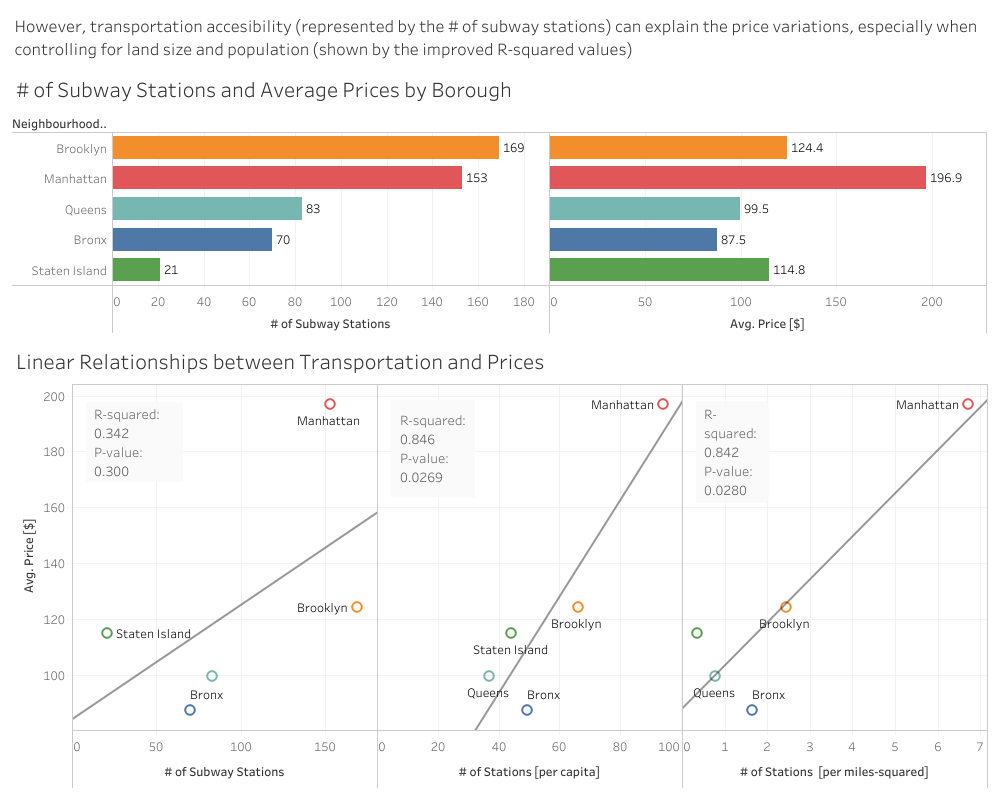

### Cost of Living
Finally, we want to examine if the cost of living in the given borough will affect lisitng prices. To kill two birds with one stone, we will examine the sale prices of NYC property sales between 2016 and 2017, thus investigating the role that cost of living and real estate prices have on determining AirBnB prices.

Source: https://www.kaggle.com/new-york-city/nyc-property-sales

Here's a preview of the dataset:

In [29]:
%%bigquery --project ba775-team-4a
SELECT * FROM `ba775-team-4a.raw_airbnb.nyc_property_sales` LIMIT 5;

,int64_field_0,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE_MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,231,1,CHELSEA,07 RENTALS - WALKUP APARTMENTS,2B,770,53,,C1,222 WEST 21ST STREET,,10011,9,0,9,2029,8540,1920,2,C1,29400000,2016-11-10 00:00:00+00:00
1,232,1,CHELSEA,07 RENTALS - WALKUP APARTMENTS,2,770,54,,C1,224 WEST 21ST STREET,,10011,16,0,16,2927,11580,1920,2,C1,-,2016-11-10 00:00:00+00:00
2,233,1,CHELSEA,07 RENTALS - WALKUP APARTMENTS,2B,772,30,,C1,229 WEST 22ND STREET,,10011,8,0,8,1588,3600,1910,2,C1,-,2016-10-28 00:00:00+00:00
3,237,1,CHELSEA,07 RENTALS - WALKUP APARTMENTS,2B,790,63,,C1,148 WEST 15TH STREET,,10011,8,0,8,2000,4100,1910,2,C1,3485000,2016-12-05 00:00:00+00:00
4,1458,1,CLINTON,07 RENTALS - WALKUP APARTMENTS,2,1058,10,,C1,441 WEST 48TH STREET,,10036,12,0,12,2510,8175,1901,2,C1,12400000,2017-06-28 00:00:00+00:00


After converting the borough code (based on the key provided on the Kaggle description) to the name and fitlering null sale prices, we ended up with the following table.

In [28]:
%%bigquery --project ba775-team-4a
SELECT CASE
WHEN BOROUGH = 1 THEN 'Manhattan'
WHEN BOROUGH = 2 THEN 'Bronx'
WHEN BOROUGH = 3 THEN 'Brooklyn'
WHEN BOROUGH = 4 THEN 'Queens'
WHEN BOROUGH = 5 THEN 'Staten Island'
END AS Borough_name,
ROUND(AVG(CAST(SALE_PRICE AS FLOAT64)),2) as Average_Sale_Price # the column was automatically imported as a string so we had to convert it into a float

FROM `ba775-team-4a.raw_airbnb.nyc_property_sales`
WHERE SALE_PRICE NOT LIKE '%-%' # filter out null values
AND CAST(SALE_PRICE AS FLOAT64) > 20 # filter out irregularly low values (usually signifies non-sale transfer of ownership like familty inheritence)
GROUP BY Borough_name

,Borough_name,Average_Sale_Price
0,Manhattan,3368041.75
1,Bronx,821701.37
2,Brooklyn,1303471.21
3,Queens,750696.10
4,Staten Island,553415.19


Let's put it together with the AirBnB set

In [27]:
%%bigquery --project ba775-team-4a
SELECT 
  neighbourhood_group,
  ROUND(AVG(price),2) as Average_Listing_Price,
  property_sales.Average_Sale_Price
FROM `ba775-team-4a.raw_airbnb.airbnb_data` AS airbnb
LEFT JOIN 
  (SELECT CASE
    WHEN BOROUGH = 1 THEN 'Manhattan'
    WHEN BOROUGH = 2 THEN 'Bronx'
    WHEN BOROUGH = 3 THEN 'Brooklyn'
    WHEN BOROUGH = 4 THEN 'Queens'
    WHEN BOROUGH = 5 THEN 'Staten Island'
    END AS Borough_name,
    ROUND(AVG(CAST(SALE_PRICE AS FLOAT64)),2) as Average_Sale_Price

    FROM `ba775-team-4a.raw_airbnb.nyc_property_sales`
    WHERE SALE_PRICE NOT LIKE '%-%'
    AND CAST(SALE_PRICE AS FLOAT64) > 20
    GROUP BY Borough_name
  ) AS property_sales
ON airbnb.neighbourhood_group = property_sales.Borough_Name
WHERE price>0
GROUP BY neighbourhood_group, property_sales.Average_Sale_Price
ORDER BY Average_Sale_Price DESC

,neighbourhood_group,Average_Listing_Price,Average_Sale_Price
0,Manhattan,196.88,3368041.75
1,Brooklyn,124.44,1303471.21
2,Bronx,87.58,821701.37
3,Queens,99.52,750696.10
4,Staten Island,114.81,553415.19


It seems that a correlation is present for the Manhattan and Brooklyn but falls apart for the last 3 boroughs. There are a lot of factors that contribute to varying property sale prices, an important factor being the size of the unit.

So what happens when we control for property size?

In [26]:
%%bigquery --project ba775-team-4a
SELECT 
  neighbourhood_group,
  ROUND(AVG(price),2) as Average_Listing_Price,
  property_sales.Average_Sale_Price_per_sqft
FROM `ba775-team-4a.raw_airbnb.airbnb_data` AS airbnb
LEFT JOIN 
  (SELECT CASE
    WHEN BOROUGH = 1 THEN 'Manhattan'
    WHEN BOROUGH = 2 THEN 'Bronx'
    WHEN BOROUGH = 3 THEN 'Brooklyn'
    WHEN BOROUGH = 4 THEN 'Queens'
    WHEN BOROUGH = 5 THEN 'Staten Island'
    END AS Borough_name,
ROUND( AVG( CAST(SALE_PRICE AS FLOAT64) / CAST(GROSS_SQUARE_FEET AS FLOAT64)  ),2) as Average_Sale_Price_per_sqft

FROM `ba775-team-4a.raw_airbnb.nyc_property_sales`
WHERE SALE_PRICE NOT LIKE '%-%'
    AND CAST(SALE_PRICE AS FLOAT64) > 20
    AND GROSS_SQUARE_FEET NOT LIKE '%-%'
    AND CAST(GROSS_SQUARE_FEET AS FLOAT64)>0
GROUP BY Borough_name
ORDER BY Average_Sale_Price_per_sqft DESC
  ) AS property_sales
ON airbnb.neighbourhood_group = property_sales.Borough_Name
WHERE price>0
GROUP BY neighbourhood_group, property_sales.Average_Sale_Price_per_sqft
ORDER BY Average_Sale_Price_per_sqft DESC

,neighbourhood_group,Average_Listing_Price,Average_Sale_Price_per_sqft
0,Manhattan,196.88,1075.54
1,Brooklyn,124.44,486.04
2,Queens,99.52,410.31
3,Staten Island,114.81,320.56
4,Bronx,87.58,245.76


When controlling the property sale price with the size of the property, the correlation seems stronger with only Queens and Staten Island breaking the pattern. There might be other factors that could explain this break in pattern, but, considering the scope of this project, we will not investigate further.

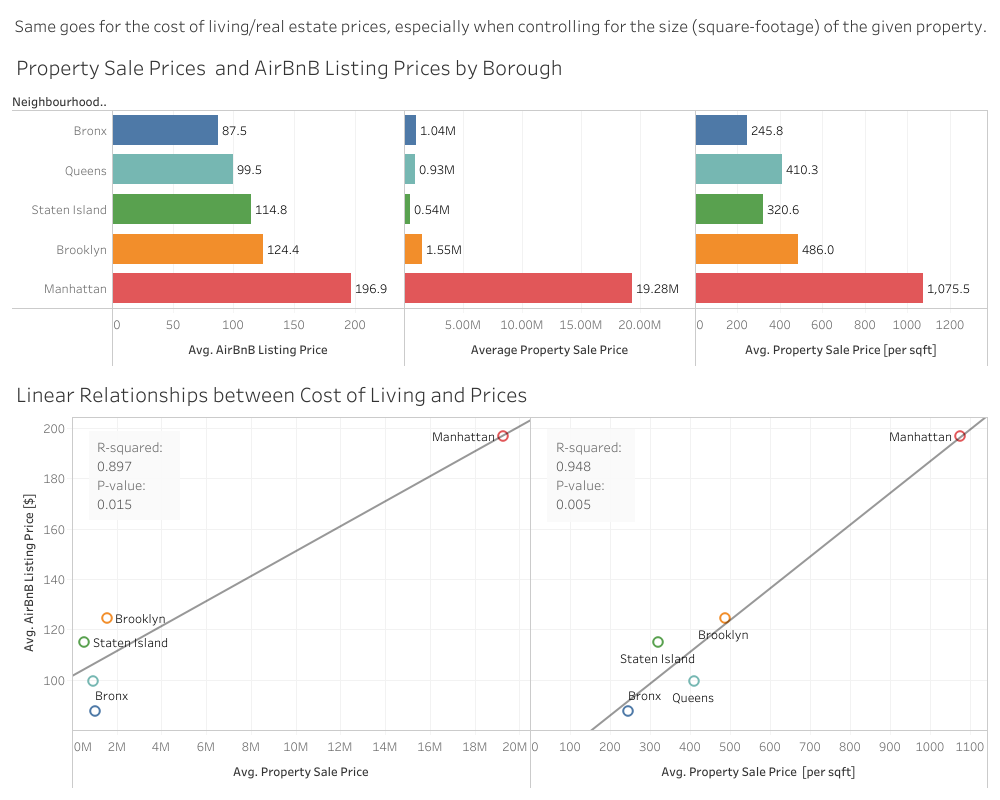

It is worth noting that when conducting a simple linear regression on AirBnB listing prices against the two variables (average property price & average property price/sqft) through Tableau, there seems to be a strong postive correlation present with R-squared values of 0.897 and 0.948 respectively. This will be discussed during the presentation.

 -----

## Data Exploration Insights


It seems each variable may be worth further exploration, or at least considered when conducting the next step of the project:
- **Listing Type:** This variable seems to show the largest variations in price. This might act as a good control variable during further exploration.
- **Neighborhood Group:** A lot of price variability present with this variable. It seems we have discovered two underlying causes for these price variations: cost of living and transportation accesssibility.
- **Review / Monthly reviews:** The bell-shape curve presents an interesting conclusion that presents opportunities for deeper investigation.
- **Availability:** A positive correlation was clearly present until we controlled for listing type. It could be interesting to see why this occurs.


---




## Predictive Model (Linear Regression)

### Developing a basic linear model
With the five variables all having a relationship of some sort with the listing price, we will try to develop an linear regression model using BQML with the variables as features. From there, we will evaluate the model and see if we can make improvements through feature engineering.

In total, we will create 3 models.
1. A baseline model that calculates the average price of a listing given their listing type and borough (using OVER BY and PARTITION methods).
2. A linear regression model using BQML with the five original variables
3. A (hopefully) improved regression model using BQML, after some feature engineering.

We will then evaluate the accuracy and predictions for the three models.

Before we begin, we wanted to create a clean version of our dataset that our model will be running; a dataset consisting of only the variables we will need. 

We used the SQL query below to develop said dataset.

In [50]:
%%bigquery --project ba775-team-4a
SELECT
  host_id,
  neighbourhood_group as borough,
  room_type,
  price,
  number_of_reviews,
  reviews_per_month,
  availability_365,
  B.Average_Sale_Price_per_sqft,
  C.stations_per_capita
FROM
  `ba775-team-4a.raw_airbnb.airbnb_data` A
LEFT JOIN (
  SELECT
    Borough_name, Average_Sale_Price_per_sqft, Average_Sale_Price
  FROM `ba775-team-4a.raw_airbnb.nyc_property_sales_cleaned`) B
  ON A.neighbourhood_group = B.Borough_name
LEFT JOIN (
  SELECT (Subway_Station_Count/ Population*1000000) stations_per_capita, Borough_Name
  FROM `ba775-team-4a.raw_airbnb.NYC_subway_cleaned`) C
  ON A.neighbourhood_group = C.Borough_name
LIMIT 5;

,host_id,borough,room_type,price,number_of_reviews,reviews_per_month,availability_365,Average_Sale_Price_per_sqft,stations_per_capita
0,88209,Manhattan,Private room,130,115,1.17,75,1075.54,93.939606
1,4230317,Manhattan,Entire home/apt,465,47,0.67,277,1075.54,93.939606
2,9522475,Manhattan,Entire home/apt,455,93,1.36,332,1075.54,93.939606
3,5081260,Manhattan,Private room,208,38,0.60,313,1075.54,93.939606
4,29769754,Manhattan,Entire home/apt,499,35,0.72,223,1075.54,93.939606


We included all 5 features we explored above and added the features that explained price variations across the boroughs. We also included host_id to split the dataset 80/20 for training and testing respectively, which was done with the following queries:

In [51]:
# 20% testing
%%bigquery --project ba775-team-4a
SELECT * FROM `ba775-team-4a.splits.model_data` 
WHERE MOD(ABS(FARM_FINGERPRINT(CAST(host_id AS STRING))),5) = 0
LIMIT 3;

,host_id,borough,room_type,price,number_of_reviews,reviews_per_month,availability_365,Average_Sale_Price_per_sqft,stations_per_capita
0,1527535,Manhattan,Entire home/apt,499,63,0.76,26,1075.54,93.939606
1,2935265,Manhattan,Private room,194,141,2.00,340,1075.54,93.939606
2,20431437,Manhattan,Entire home/apt,495,159,2.83,129,1075.54,93.939606


In [52]:
# 20% testing
%%bigquery --project ba775-team-4a
SELECT COUNT(*) rows_for_testing FROM `ba775-team-4a.splits.model_data` 
WHERE MOD(ABS(FARM_FINGERPRINT(CAST(host_id AS STRING))),5) = 0
LIMIT 3;

,rows_for_testing
0,9746


In [53]:
# 80% testing
%%bigquery --project ba775-team-4a
SELECT * FROM `ba775-team-4a.splits.model_data` 
WHERE MOD(ABS(FARM_FINGERPRINT(CAST(host_id AS STRING))),5) <> 0
LIMIT 3;

,host_id,borough,room_type,price,number_of_reviews,reviews_per_month,availability_365,Average_Sale_Price_per_sqft,stations_per_capita
0,88209,Manhattan,Private room,130,115,1.17,75,1075.54,93.939606
1,4230317,Manhattan,Entire home/apt,465,47,0.67,277,1075.54,93.939606
2,9522475,Manhattan,Entire home/apt,455,93,1.36,332,1075.54,93.939606


In [54]:
%%bigquery --project ba775-team-4a
SELECT COUNT(*) rows_for_training FROM `ba775-team-4a.splits.model_data` 
WHERE MOD(ABS(FARM_FINGERPRINT(CAST(host_id AS STRING))),5) <> 0
LIMIT 3;

,rows_for_training
0,39149


### Baseline Model

In [55]:
%%bigquery --project ba775-team-4a
SELECT
  room_type,
  borough,
  price,
  AVG(price) OVER(PARTITION BY room_type, borough) AS avgprice_type_loc
FROM
  `ba775-team-4a.splits.test`
WHERE price > 0
LIMIT 5

,room_type,borough,price,avgprice_type_loc
0,Entire home/apt,Bronx,140,128.554217
1,Entire home/apt,Bronx,98,128.554217
2,Entire home/apt,Bronx,49,128.554217
3,Entire home/apt,Bronx,75,128.554217
4,Entire home/apt,Bronx,89,128.554217


As you can see, this 'model' simply averages the price of a listing given its location and type. We assume that this will not be a good predictor but, for the purposes of this project, will act as a decent baseline for our simple linear models.

In [56]:
%%bigquery --project ba775-team-4a
SELECT
 SQRT(AVG(POW((price - avgprice_type_loc),2))) rmse
FROM (
  SELECT
    room_type,
    borough,
    price,
    AVG(price) OVER(PARTITION BY room_type, borough) AS avgprice_type_loc
  FROM
    `ba775-team-4a.splits.test`
  WHERE
    price > 0)

,rmse
0,267.996239


The baseline model presents a rmse of 268. We will compare this value to the rmse of our other models.

### First BQML Linear Reg Model

The following is the SQL code we used to develop the model on BQML:

In [ ]:
# %%bigquery --project ba775-team-4a
CREATE OR REPLACE MODEL `models.prices_model_medium`
OPTIONS
  (model_type='linear_reg',
    input_label_cols=['price']) AS

  SELECT
    price,
    borough,
    number_of_reviews,
    reviews_per_month,
    availability_365, 
    room_type 
FROM
    `ba775-team-4a.splits.train`
WHERE # filtering out 0 values found in the columns
    availability_365 > 0
    AND price > 0

The model was saved in our Big Query 'models' dataset and ended with 'medium' to tag the methodology used to write the code, which was found in the following Medium article: https://medium.com/eliiza-ai/introduction-to-linear-regression-with-bigquery-ml-b62d134e0c18

Following the development, we now need to evaluate its performance against the test dataset using the ML.EVALUATE method.

The developed model was evaluated with the following code:

In [57]:
%%bigquery --project ba775-team-4a

SELECT
  SQRT(mean_squared_error) AS rmse, * 
FROM
  ML.EVALUATE(MODEL models.prices_model_medium,
  (

  SELECT
    price,
    borough,
    number_of_reviews,
    reviews_per_month,
    availability_365, 
    room_type 
FROM
    `ba775-team-4a.splits.test`
WHERE
    availability_365 > 0
    AND price > 0
  ))

,rmse,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,256.113269,76.365854,65594.006354,0.343606,46.366179,0.100325,0.100361


Comparing this model's RMSE to the baseline 'model', it seems that the model performs better at predicting listing prices. Now let's see if we can improve it through some feature engineering.

### Improved BQML Linear Model

This second model will now replace the location feature with the number of subway stations per capita (measure of transportation accessibility) and average property sale value per sqft (measure of cost of living).

Additionally, after doing some quick data exploration ofr the *price* variable, we discovered that there were a few listings that had extremely high prices; a total of 45 listings (out of 48,895) with a price of over $3000 (see query below). We assumed that these few high-priced listings (i.e. outliers) were throwing off our predictive model, so we decided to exclude them during this version.



In [63]:
%%bigquery --project ba775-team-4a
SELECT
  COUNT(*) listings
FROM
  `ba775-team-4a.raw_airbnb.airbnb_data`
WHERE
  price>3000

,listings
0,45


The following queries were used to develop (with the training set) and evaluate (against the test set) model:

In [ ]:
# %%bigquery --project ba775-team-4a
CREATE OR REPLACE MODEL
  `models.prices_model_improved` OPTIONS (model_type='linear_reg',
    input_label_cols=['price']) AS
SELECT
  price,
  number_of_reviews,
  reviews_per_month,
  availability_365,
  room_type,
  Average_Sale_Price_per_sqft,
  stations_per_capita
FROM
  `ba775-team-4a.splits.train`
WHERE
  # filtering out 0 values found in the columns
  availability_365 > 0
  AND price > 0
  AND price <= 3000

In [64]:
%%bigquery --project ba775-team-4a

SELECT
  SQRT(mean_squared_error) AS rmse, * 
FROM
  ML.EVALUATE(MODEL models.prices_model_improved,
  (

  SELECT
  price,
  Average_Sale_Price_per_sqft,
  stations_per_capita,
  number_of_reviews,
  reviews_per_month,
  availability_365,
  room_type
FROM
  `ba775-team-4a.splits.test`
WHERE
    availability_365 > 0
    AND price > 0
    AND price <=3000
  ))

,rmse,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,132.450599,67.952247,17543.161128,0.31112,44.52109,0.2438,0.243914


It seems that there are significant improvements to the RMSE score with this model. We did some testing (created other models without filtering outliers and without feature engineering) and found that both actions improved RMSE score, though filtering out the outliers attributed to the largest improvements in RMSE.

With that said, because we filtered out high-priced listings, our model only maintains that level of accuracy for listings priced below 3000 dollars. Considering how few the number of high-priced listings there are, this is a trade-off that our team was fine with.

Ultimately, we had hoped to use this model as a way to predict the prices of AirBnB listings.

For a glimpse of the predictions made by the last 'improved' model, see below:

In [65]:
%%bigquery --project ba775-team-4a
SELECT * FROM
ML.PREDICT(MODEL `models.prices_model_improved`,
  (
  SELECT
  price,
  Average_Sale_Price_per_sqft,
  stations_per_capita,
  number_of_reviews,
  reviews_per_month,
  availability_365,
  room_type
FROM
  `ba775-team-4a.splits.test`
WHERE
    availability_365 > 0
    AND price > 0
  ))
LIMIT 10;

,predicted_price,price,Average_Sale_Price_per_sqft,stations_per_capita,number_of_reviews,reviews_per_month,availability_365,room_type
0,217.150247,499,1075.54,93.939606,63,0.76,26,Entire home/apt
1,128.996210,194,1075.54,93.939606,141,2.00,340,Private room
2,207.884183,495,1075.54,93.939606,159,2.83,129,Entire home/apt
3,216.844384,195,1075.54,93.939606,60,1.18,16,Entire home/apt
4,246.902188,350,1075.54,93.939606,74,1.60,247,Entire home/apt
5,253.963728,125,1075.54,93.939606,88,1.91,320,Entire home/apt
6,108.446887,190,1075.54,93.939606,53,1.42,38,Private room
7,220.387186,150,1075.54,93.939606,40,1.05,4,Entire home/apt
8,126.648905,99,1075.54,93.939606,35,1.62,129,Private room
9,102.111105,115,1075.54,93.939606,75,5.80,11,Private room


--------

## Restrictions and Limitations


### Data Exploration
#### Reviews
- We were conflicted in whether or not to include zero-review listings; zero-review listings could be a signal for null listings (i.e. outliers that may skew our results); on the other hand, it may be important to include them so we don't alienate new AirBnB listings, which tend to have no reviews yet.

#### Listing Type
- When filtering and controlling for different locations, the pattern we found broke. This was most likely due to the fact that when breaking down at the neighborhood level, the sample size might be too small to draw significant/useful insights
- Due to the limitation of the dataset, we could not investigate further why the listing type affects prices. Ideally, if we had more time and dataset with more features, we would try to invesitgate why the price variations exist. For example, listing types can act as a signal to the number of people the lisitng accomodates, which might be a better explaination for the price variations.

#### Locations
- Our first issue was deciding how granular we should get with this element. The dataset goes as deep to the neighborhood-level. We ultimately opted to investigate at the borough-level because it would be easier to pick up insights from 5 groups when compared to investigating 221 neighborhoods. Additionally, it would be easier to match with other datasets. Given more time, we may have opted to investigate at the neighbourhood level.
- We also had to hypothesize the underlying causes for the variations in prices across neighborhoods
- Following that, we had to determine how to test for those underlying causes. This was harder for some hypotheses than others.
  - For example, when investigating safety, we knew (valid) crime reports would be an excellent measure and the NYPD kept a comprehensive public dataset on this(albeit large and a little difficult to process)
  - Alternatively, a borough's transportation accessibility was more difficult to asses. We were unsure about the best way to evaluate this, and even when we had an idea, the datasets may not have been the easiest to process. For example, we wanted to use NYC taxi data from 2019, but after an hour of downloading the dataset, the download was barely complete, so we opted for another method/dataset.
- Once we had a cleaned dataset to test our hypothesis against, if the result did not confirm our hypothesis, we had to conduct further research to form a new hypothesis to test. For example, coming up with the idea to control for property size to improve the correlation.
- Other data pre-processing issues includes:
  - Misaligned values for JOINing dataset on the boroughs (sometimes it would be in different cases, other times in codes)
  - Some datasets required manual determination of the schema, including adding a date/time as a string then parsing and casting to filter for a specific year.

### Visualization Challenges (Tableau)
- Custom SQLs did not work for our Tableau workbook, so we had to either...
  - learn how to do some of thing we did on BQ on Tableau; for example, breaking down variables into quintiles.
  - create a new table on BQ with the query results and import the table seperately
- Create a user-friendly flow our workbook so notebook readers can understand our dashboard without outside explanation AND the team can easily refer to the dashboard during the presentation

### Given more time...
- we would have used a dataset with additional features that may do a better job in predicting prices. For example, the number of people the listing accomodates or the review score of the listing.
- we would checked for overfitting for our ML models.